# Import

In [1]:
# Packages
from pandas import read_csv, DataFrame
from scipy.stats import pearsonr, f
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from numpy import array, mean, append
from matplotlib.pyplot import savefig, xlim, ylim, subplots
from os import makedirs
from IPython.display import display
from statsmodels.formula.api import glm

In [2]:
# Helpers
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            
    return pvalues

# https://towardsdatascience.com/cronbachs-alpha-theory-and-application-in-python-d2915dd63586
def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = append(sum_, rs)
        
    mean_r = mean(rs)
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

# https://stackoverflow.com/questions/27328623/anova-test-for-glm-in-python
def calculate_nested_f_statistic(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

# Setup

In [3]:
# Load data and setup output dir
data = read_csv("data/anon.csv", sep="\t")
makedirs("output", exist_ok=True)

In [4]:
# Clean data
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

data["hand_number"] = data["hand"].map({
    "Right-handed": 0,
    "Left-handed": 1
})

In [5]:
# Composite values
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)

In [6]:
# What columns do we care about and what dependent variable col are we trying to predict?
features = [
    "total_events",
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    "n_puz_no_basic",
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    "n_interm",
    # "n_adv", # missing over 30 values
    "total_active",
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    "diff_event2",
    # "diff_event3", # missing over 30 values
    "different_event",
    # "sbst", # dependent variable
    "gender_number",
    "hand_number",
    "enjoyment",
    # "sri" # dependent variable
]

labels = ["sbst", "sri"]
everything = features + labels

# Descriptive Stats

In [7]:
# Display how many missing values are in each column
for col in everything:
    num = data[col].isna().sum()
    percent = num / len(data) * 100
    print(f"Variable: {col:20} Count Missing: {num:2}     Percent Missing: {percent:.4}")

Variable: total_events         Count Missing:  0     Percent Missing: 0.0
Variable: total_breaks         Count Missing:  0     Percent Missing: 0.0
Variable: total_submit         Count Missing:  0     Percent Missing: 0.0
Variable: total_snapshot       Count Missing:  0     Percent Missing: 0.0
Variable: total_view           Count Missing:  0     Percent Missing: 0.0
Variable: total_manipulate     Count Missing:  0     Percent Missing: 0.0
Variable: n_puzzle             Count Missing:  0     Percent Missing: 0.0
Variable: n_puz_no_basic       Count Missing:  0     Percent Missing: 0.0
Variable: p_puz_no_basic       Count Missing:  0     Percent Missing: 0.0
Variable: n_complete           Count Missing:  0     Percent Missing: 0.0
Variable: n_tutorial           Count Missing:  0     Percent Missing: 0.0
Variable: n_interm             Count Missing:  9     Percent Missing: 19.15
Variable: total_active         Count Missing:  0     Percent Missing: 0.0
Variable: complete_active      Count

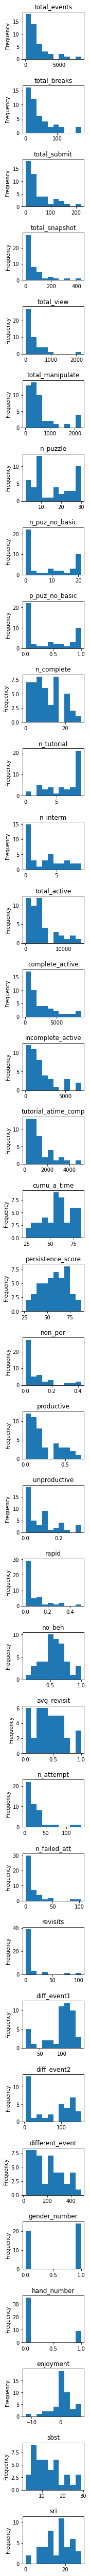

In [8]:
fig, axs = subplots(len(everything), 1)
fig.set_size_inches(3, 2 * len(everything))
fig.tight_layout(pad=3.0)
for i, col in enumerate(everything):
    data[col].plot(kind="hist", ax=axs[i], title=col)

fig.savefig("output/hists.png")

In [9]:
# Percentages for the binary variables, gender and handedness
percent_female = len(data[data["gender_number"] == 1]) / len(data) * 100
print(f"Percent of students that are female: {percent_female:.4}")

percent_left = len(data[data["hand_number"] == 1]) / len(data) * 100
print(f"Percent of students that are left-handed: {percent_left:.4}")

Percent of students that are female: 51.06
Percent of students that are left-handed: 19.15


In [10]:
# Correlation analysis
corr = data[everything].corr()
corr.to_csv("output/corr.csv", sep="\t")
display(corr)

,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,n_complete,...,n_failed_att,revisits,diff_event1,diff_event2,different_event,gender_number,hand_number,enjoyment,sbst,sri
total_events,1.000000,0.645940,0.831245,0.878537,0.873332,0.969912,0.729461,0.726490,0.726490,0.649441,...,0.861734,0.822404,0.597588,0.635660,0.853643,0.132064,0.191423,0.316903,0.121307,0.080549
total_breaks,0.645940,1.000000,0.810802,0.430055,0.321672,0.752608,0.635879,0.622537,0.622537,0.480924,...,0.523672,0.435440,0.501087,0.414560,0.643709,0.121806,0.038819,0.159102,-0.016558,0.022078
total_submit,0.831245,0.810802,1.000000,0.549738,0.566189,0.878835,0.738982,0.730438,0.730438,0.552429,...,0.761528,0.674068,0.595123,0.603175,0.789717,0.125847,0.028317,0.205949,-0.011722,-0.112170
total_snapshot,0.878537,0.430055,0.549738,1.000000,0.878556,0.802186,0.528741,0.534731,0.534731,0.588544,...,0.703888,0.719344,0.441536,0.509094,0.692253,0.178330,0.242481,0.387691,0.203829,0.229070
total_view,0.873332,0.321672,0.566189,0.878556,1.000000,0.754409,0.537787,0.526580,0.526580,0.590044,...,0.700245,0.710226,0.508646,0.524521,0.695472,0.152849,0.384464,0.295414,0.124007,0.111049
total_manipulate,0.969912,0.752608,0.878835,0.802186,0.754409,1.000000,0.763683,0.762474,0.762474,0.640513,...,0.858777,0.803405,0.592591,0.616873,0.854707,0.101037,0.103332,0.305830,0.136284,0.099319
n_puzzle,0.729461,0.635879,0.738982,0.528741,0.537787,0.763683,1.000000,0.979048,0.979048,0.842271,...,0.623196,0.496214,0.654089,0.829138,0.956391,0.004649,0.134867,0.300282,0.302955,0.129835
n_puz_no_basic,0.726490,0.622537,0.730438,0.534731,0.526580,0.762474,0.979048,1.000000,1.000000,0.809996,...,0.640030,0.513893,0.502394,0.823465,0.932320,-0.056788,0.163976,0.356640,0.294247,0.175193
p_puz_no_basic,0.726490,0.622537,0.730438,0.534731,0.526580,0.762474,0.979048,1.000000,1.000000,0.809996,...,0.640030,0.513893,0.502394,0.823465,0.932320,-0.056788,0.163976,0.356640,0.294247,0.175193
n_complete,0.649441,0.480924,0.552429,0.588544,0.590044,0.640513,0.842271,0.809996,0.809996,1.000000,...,0.442110,0.442387,0.568694,0.833165,0.892616,-0.120111,0.173390,0.359677,0.558489,0.323951


In [11]:
# p values
pvals = DataFrame(calculate_pvalues(data[everything]))
pvals.to_csv("output/pvals.csv", sep="\t")
display(pvals)

,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,n_complete,...,n_failed_att,revisits,diff_event1,diff_event2,different_event,gender_number,hand_number,enjoyment,sbst,sri
total_events,0.0,0.0004,0.0,0.0,0.0,0.0,0.0001,0.0001,0.0001,0.0005,...,0.0,0.0,0.0005,0.0002,0.0,0.5284,0.4204,0.0351,0.9983,0.6857
total_breaks,0.0004,0.0,0.0,0.0272,0.212,0.0,0.0005,0.0005,0.0005,0.0387,...,0.0068,0.0286,0.0142,0.0249,0.0004,0.4505,0.9747,0.0938,0.4538,0.896
total_submit,0.0,0.0,0.0,0.004,0.0051,0.0,0.0,0.0,0.0,0.0139,...,0.0,0.0001,0.001,0.0006,0.0,0.5777,0.8043,0.0817,0.382,0.3995
total_snapshot,0.0,0.0272,0.004,0.0,0.0,0.0,0.0049,0.005,0.005,0.0002,...,0.0,0.0,0.0081,0.0031,0.0,0.4057,0.2359,0.0133,0.3879,0.1265
total_view,0.0,0.212,0.0051,0.0,0.0,0.0,0.0143,0.0172,0.0172,0.0014,...,0.0001,0.0,0.0028,0.0035,0.0,0.4468,0.032,0.0718,0.8646,0.484
total_manipulate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0009,...,0.0,0.0,0.0008,0.0004,0.0,0.6458,0.8612,0.0495,0.9437,0.6442
n_puzzle,0.0001,0.0005,0.0,0.0049,0.0143,0.0,0.0,0.0,0.0,0.0,...,0.0005,0.0066,0.0097,0.0,0.0,0.9174,0.7254,0.0286,0.4006,0.2068
n_puz_no_basic,0.0001,0.0005,0.0,0.005,0.0172,0.0,0.0,0.0,0.0,0.0,...,0.0004,0.0056,0.0493,0.0,0.0,0.7456,0.5717,0.0245,0.3192,0.1612
p_puz_no_basic,0.0001,0.0005,0.0,0.005,0.0172,0.0,0.0,0.0,0.0,0.0,...,0.0004,0.0056,0.0493,0.0,0.0,0.7456,0.5717,0.0245,0.3192,0.1612
n_complete,0.0005,0.0387,0.0139,0.0002,0.0014,0.0009,0.0,0.0,0.0,0.0,...,0.0337,0.0177,0.0648,0.0,0.0,0.3364,0.3975,0.0043,0.002,0.0009


In [12]:
# Cronbach's Alpha
alpha = cronbach_alpha(data[labels]) # TODO this gives a single alpha, but we want more?
print(f"Cronbach's Alpha for SRI and SBST: {alpha}")

Cronbach's Alpha for SRI and SBST: 0.757301787558002


# ANOVA

In [13]:
# ANOVA with SRI and gender
model0 = glm("sri ~ 1", data).fit()
print(model0.summary())

print()
model1 = glm("sri ~ 1 + gender_number", data).fit()
print(model1.summary())

f_stat, p_value = calculate_nested_f_statistic(model0, model1)
result = "fail to reject"
if p_value < 0.05:
    "reject"

print()
print(f"We {result} the null hypothesis in favor of the alternative that a linear\nmodel including the gender is a better predictor of sri than the mean\nalone (alpha=0.05, F={f_stat:.4}, p={p_value:.4}).")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    sri   No. Observations:                   44
Model:                            GLM   Df Residuals:                       43
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          46.112
Method:                          IRLS   Log-Likelihood:                -146.21
Date:                Tue, 30 Nov 2021   Deviance:                       1982.8
Time:                        18:00:41   Pearson chi2:                 1.98e+03
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0002622
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.0682      1.024     15.696      0.0

In [14]:
# Same thing but with SBST
model0 = glm("sbst ~ 1", data).fit()
print(model0.summary())

print()
model1 = glm("sbst ~ 1 + gender_number", data).fit()
print(model1.summary())

f_stat, p_value = calculate_nested_f_statistic(model0, model1)
result = "fail to reject"
if p_value < 0.05:
    "reject"

print()
print(f"We {result} the null hypothesis in favor of the alternative that a linear\nmodel including the gender is a better predictor of sbst than the mean\nalone (alpha=0.05, F={f_stat:.4}, p={p_value:.4}).")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   sbst   No. Observations:                   42
Model:                            GLM   Df Residuals:                       41
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          50.214
Method:                          IRLS   Log-Likelihood:                -141.33
Date:                Tue, 30 Nov 2021   Deviance:                       2058.8
Time:                        18:00:41   Pearson chi2:                 2.06e+03
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0002880
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0714      1.093     11.955      0.0

# Random Forest

In [15]:
# Helper to run all the steps for a given dependent variable
def run_random_forest(good_data, dep_col):
    # Split into labels and features
    labels = array(good_data[dep_col])
    features = array(good_data.drop(dep_col, axis=1))
    
    # Split into train and test
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)
    print("Training Features Shape:", train_features.shape)
    print("Training Labels Shape:", train_labels.shape)
    print("Testing Features Shape:", test_features.shape)
    print("Testing Labels Shape:", test_labels.shape)
    
    # Fit model
    rf = RandomForestRegressor(n_estimators=1000, random_state=42)
    rf.fit(train_features, train_labels)
    
    # Check model error
    predictions = rf.predict(test_features)
    errors = abs(predictions - test_labels)
    print("Mean Absolute Error:", round(mean(errors), 2), "degrees.")
    
    # Display importance of each features
    importances = list(rf.feature_importances_)
    feature_importances = [
        (feature, round(importance, 2))
        for feature, importance
        in zip(list(data.drop(dep_col, axis=1).columns), importances)
    ]

    feature_importances = sorted(feature_importances, reverse=True, key=lambda x: x[1])
    for feature, importance in feature_importances:
        print(f"Variable: {feature:20} Importance: {importance}")
    
    # Plot actual vs. predicted
    good_data["Predicted"] = rf.predict(features)
    good_data.plot(
        kind="scatter",
        x=dep_col,
        y="Predicted"
    )

    savefig(f"output/predicted_{dep_col}.png")

Training Features Shape: (22, 34)
Training Labels Shape: (22,)
Testing Features Shape: (8, 34)
Testing Labels Shape: (8,)
Mean Absolute Error: 3.68 degrees.
Variable: revisits             Importance: 0.6
Variable: incomplete_active    Importance: 0.04
Variable: int_atime_incomp     Importance: 0.04
Variable: p_puz_no_basic       Importance: 0.03
Variable: n_tutorial           Importance: 0.03
Variable: complete_active      Importance: 0.02
Variable: tutorial_atime_comp  Importance: 0.02
Variable: adv_atime_comp       Importance: 0.02
Variable: adv_atime_incomp     Importance: 0.02
Variable: no_beh               Importance: 0.02
Variable: user_sha1            Importance: 0.01
Variable: total_events         Importance: 0.01
Variable: total_manipulate     Importance: 0.01
Variable: n_puzzle             Importance: 0.01
Variable: n_puz_no_basic       Importance: 0.01
Variable: n_interm             Importance: 0.01
Variable: total_active         Importance: 0.01
Variable: int_atime_comp    

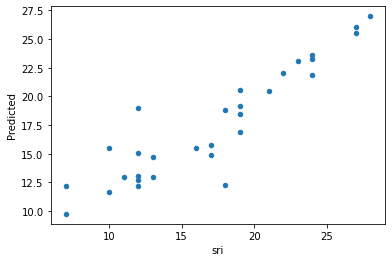

In [16]:
good_data = data[data["sri"] > 0][everything].dropna()
run_random_forest(good_data, "sri")

Training Features Shape: (23, 34)
Training Labels Shape: (23,)
Testing Features Shape: (8, 34)
Testing Labels Shape: (8,)
Mean Absolute Error: 4.73 degrees.
Variable: revisits             Importance: 0.59
Variable: int_atime_incomp     Importance: 0.06
Variable: total_events         Importance: 0.04
Variable: adv_atime_incomp     Importance: 0.04
Variable: n_tutorial           Importance: 0.03
Variable: tutorial_atime_incomp Importance: 0.03
Variable: p_puz_no_basic       Importance: 0.02
Variable: total_active         Importance: 0.02
Variable: adv_atime_comp       Importance: 0.02
Variable: total_breaks         Importance: 0.01
Variable: total_snapshot       Importance: 0.01
Variable: n_complete           Importance: 0.01
Variable: n_interm             Importance: 0.01
Variable: complete_active      Importance: 0.01
Variable: incomplete_active    Importance: 0.01
Variable: tutorial_atime_comp  Importance: 0.01
Variable: int_atime_comp       Importance: 0.01
Variable: cumu_a_time     

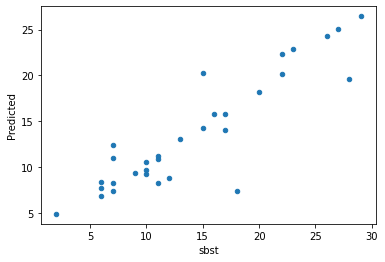

In [17]:
good_data = data[data["sbst"] > 0][everything].dropna()
run_random_forest(good_data, "sbst")